In [6]:
# The only 3 lines you need to install and use AMPL with any solver on Colab
%pip install -q amplpy pandas matplotlib seaborn
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi"],  # modules to install
    license_uuid="your-license-uuid",  # license to use
)  # instantiate AMPL object and register magics

In [7]:
import pandas as pd

# Power plant characteristics and demand profile
power_plants = df = pd.DataFrame(
    {
        "Capacity_MW": [500, 600, 400, 450, 1000, 200, 300],
        "Cost_per_MW": [50, 55, 40, 42, 30, 0, 0],  # Solar & Wind have no fuel cost
        "CO2_Emission_per_MW": [1.2, 1.1, 0.5, 0.4, 0, 0, 0],  # Carbon emissions per MW
        "Ramp_Rate": [100, 120, 80, 90, 50, 300, 400],  # Max MW change per hour
    },
    index=["Coal_1", "Coal_2", "Gas_1", "Gas_2", "Nuclear_1", "Solar_1", "Wind_1"],
)
demand = pd.DataFrame({
    "Demand_MW": [800, 750, 700, 680, 660, 700, 850, 1000, 1200, 1300, 1400, 1350,
                  1250, 1150, 1100, 1080, 1050, 1100, 1150, 1200, 1300, 1200, 1000, 900]
}, index=range(24))

In [8]:
%%writefile power.mod
set PLANTS;
set HOURS;
param Capacity{PLANTS};
param Cost{PLANTS};
param CO2_Emission{PLANTS};
param Demand{HOURS};
param RampRate{PLANTS};
var Gen{PLANTS, HOURS} >= 0;
# Objective: Minimize cost while considering emissions
minimize TotalCost:
    sum {p in PLANTS, t in HOURS} Cost[p] * Gen[p,t];
# Meet demand with 10% spinning reserve
subject to MeetDemand {t in HOURS}:
    sum {p in PLANTS} Gen[p,t] >= 1.1 * Demand[t];
# Enforce capacity limits
subject to CapacityLimit {p in PLANTS, t in HOURS}:
    Gen[p,t] <= Capacity[p];
# Ramp rate constraint (except for first hour)
subject to RampConstraint {p in PLANTS, t in HOURS: t > 1}:
    abs(Gen[p,t] - Gen[p,t-1]) <= RampRate[p];
# Solar and Wind availability constraints
subject to SolarConstraint {t in HOURS: t < 6 or t > 18}:
    Gen['Solar_1', t] = 0;
subject to WindConstraint {t in HOURS}:
    Gen['Wind_1', t] <= 300;  # Assuming wind variation

Overwriting power.mod


In [9]:
ampl = AMPL()
# Load the model
ampl.read("power.mod")
# Load pandas data into AMPL
ampl.set["PLANTS"] = power_plants.index
ampl.set["HOURS"] = demand.index
ampl.param["Capacity"] = power_plants["Capacity_MW"]
ampl.param["Cost"] = power_plants["Cost_per_MW"]
ampl.param["CO2_Emission"] = power_plants["CO2_Emission_per_MW"]
ampl.param["Demand"] = demand["Demand_MW"]
ampl.param["RampRate"] = power_plants["Ramp_Rate"]
# Solve with Gurobi
ampl.solve(solver="gurobi", gurobi_options="outlev=0")
assert ampl.solve_result == "solved"
# Extract results into a pandas dataframe
generation = ampl.var["Gen"].to_pandas()

Gurobi 12.0.1:   tech:outlev = 0
Gurobi 12.0.1: optimal solution; objective 549930
52 simplex iterations
1 branching node


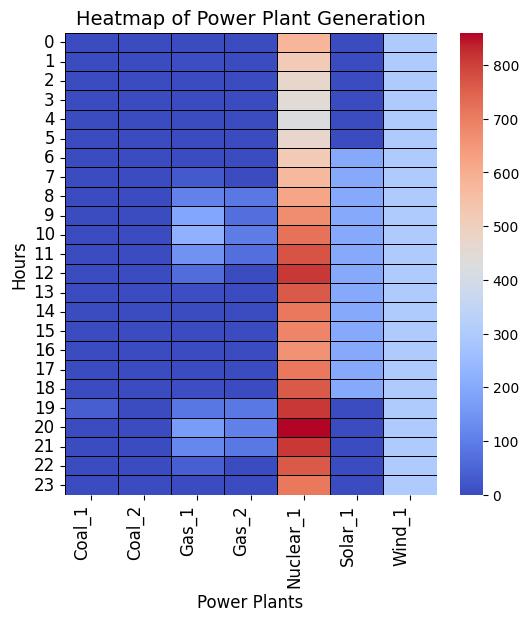

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

df = generation.unstack()
df.columns = df.columns.droplevel(0)

# Create a heatmap
plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    df.T, annot=False, fmt=".1f", cmap="coolwarm", linewidths=0.5, linecolor="black"
)

# Set title and labels
plt.title("Heatmap of Power Plant Generation", fontsize=14)
plt.xticks(fontsize=12, rotation=90, ha="right")
plt.yticks(fontsize=12, rotation=0)
plt.xlabel("Power Plants", fontsize=12)
plt.ylabel("Hours", fontsize=12)

# Show the heatmap
plt.show()

[AMPL Website](https://ampl.com) | [AMPL Forum](https://discuss.ampl.com) | [AMPL Colab Examples](https://ampl.com/colab/) | [MO-Book](https://ampl.com/mo-book/) | [Streamlit Apps](https://ampl.com/streamlit/) | [Start Free Now](https://ampl.com/trial/) | [Follow us on LinkedIn!](https://www.linkedin.com/company/ampl)

[![Hits](https://h.ampl.com/https://github.com/ampl/amplcolab/blob/master/template/minimal.ipynb)](https://colab.ampl.com)